# Semi-supervised Community Detection using Graph Neural Networks

The karate club is a social network that includes 34 members and documents pairwise links between members who interact outside the club. The club later divides into two communities led by the instructor (node 0) and the club president (node 33). The network is visualized as follows with the color indicating the community.

<img src='images/karat_club.png' align='center' width="400px" height="300px" />

In this tutorial, you will learn:

* Formulate the community detection problem as a semi-supervised node classification task.
* Build a GraphSAGE model, a popular Graph Neural Network architecture proposed by [Hamilton et al.](https://arxiv.org/abs/1706.02216)
* Train the model and understand the result.

In [8]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import pandas as pd

In [9]:
def load_karate():
    nodes_data = pd.read_csv('../../dataset/karate/nodes.csv')
    edges_data = pd.read_csv('../../dataset/karate/edges.csv')
    src = edges_data['Src'].to_numpy()
    dst = edges_data['Dst'].to_numpy()
    g = dgl.graph((src, dst))
    club = nodes_data['Club'].to_list()
    club = torch.tensor([c == 'Officer' for c in club]).long()
    club_onehot = torch.nn.functional.one_hot(club)
    g.ndata.update({'club' : club, 'club_onehot' : club_onehot})
    return g


## Community detection as node classification

The study of community structure in graphs has a long history. Many proposed methods are *unsupervised* (or *self-supervised* by recent definition), where the model predicts the community labels only by connectivity. Recently, [Kipf et al.,](https://arxiv.org/abs/1609.02907) proposed to formulate the community detection problem as a semi-supervised node classification task. With the help of only a small portion of labeled nodes, a GNN can accurately predict the community labels of the others.

In this tutorial, we apply Kipf's setting to the Zachery's Karate Club network to predict the community membership, where only the labels of a few nodes are used.

In [10]:
# ----------- 0. load graph -------------- #
g = load_karate()
print(g)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'club': Scheme(shape=(), dtype=torch.int64), 'club_onehot': Scheme(shape=(2,), dtype=torch.int64)}
      edata_schemes={})


In the original Zachery's Karate Club graph, nodes are feature-less. (The `'Age'` attribute is an artificial one mainly for tutorial purposes). For feature-less graph, a common practice is to use an embedding weight that is updated during training for every node.

We can use PyTorch's `Embedding` module to achieve this.

In [14]:
# ----------- 1. node features -------------- #
node_embed = nn.Embedding(g.number_of_nodes(), 5)  # Every node has an embedding of size 5.
inputs = node_embed.weight                         # Use the embedding weight as the node features.
nn.init.xavier_uniform_(inputs)
print(inputs)

Parameter containing:
tensor([[ 0.3379,  0.2888, -0.2318, -0.1117,  0.2320],
        [-0.3737, -0.2545, -0.3362, -0.1747,  0.0176],
        [-0.1754, -0.0490,  0.2550,  0.1895, -0.3335],
        [-0.2852,  0.1928, -0.3415,  0.2742,  0.1351],
        [-0.0638,  0.1940,  0.3714, -0.2537, -0.2314],
        [-0.3334, -0.3076,  0.1655,  0.1656,  0.0703],
        [ 0.0497, -0.3804,  0.0224, -0.1836, -0.3727],
        [ 0.1040,  0.3661,  0.0197,  0.2288, -0.3025],
        [-0.1374,  0.3825,  0.0540,  0.1695, -0.2877],
        [ 0.1738, -0.0148, -0.0520, -0.2964,  0.2516],
        [-0.1693, -0.0696, -0.3336,  0.2552,  0.3289],
        [-0.1909,  0.2573, -0.0707, -0.0825,  0.1722],
        [-0.3595, -0.1573, -0.0550,  0.1252,  0.2260],
        [ 0.1137,  0.1644, -0.3903,  0.0747,  0.0685],
        [-0.1477, -0.1825,  0.1176,  0.2345,  0.0598],
        [-0.2787, -0.1978,  0.1186, -0.1570,  0.1404],
        [ 0.3752, -0.3062,  0.3393,  0.1429, -0.1822],
        [-0.2808, -0.1382,  0.0906,  0.3431

The community label is stored in the `'club'` node feature (0 for instructor, 1 for club president). Only nodes 0 and 33 are labeled.

In [15]:
labels = g.ndata['club']
labeled_nodes = [0, 33]
print('Labels', labels[labeled_nodes])

Labels tensor([0, 1])


## Define a GraphSAGE model

Our model consists of two layers, each computes new node representations by aggregating neighbor information. The equations are:

$$
h_{\mathcal{N}(v)}^k\leftarrow \text{AGGREGATE}_k\{h_u^{k-1},\forall u\in\mathcal{N}(v)\}
$$

$$
h_v^k\leftarrow \sigma\left(W^k\cdot \text{CONCAT}(h_v^{k-1}, h_{\mathcal{N}(v)}^k) \right)
$$

DGL provides implementation of many popular neighbor aggregation modules. They all can be invoked easily with one line of codes. See the full list of supported [graph convolution modules](https://docs.dgl.ai/api/python/nn.pytorch.html#module-dgl.nn.pytorch.conv).

In [16]:
from dgl.nn import SAGEConv

# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, num_classes, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Create the model with given dimensions 
# input layer dimension: 5, node embeddings
# hidden layer dimension: 16
# output layer dimension: 2, the two classes, 0 and 1
net = GraphSAGE(5, 16, 2)

In [17]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(net.parameters(), node_embed.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(100):
    # forward
    logits = net(g, inputs)

    # compute loss
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels[labeled_nodes])

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    all_logits.append(logits.detach())

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

/home/ki/repos/dgl2/venv/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:352: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), "Cannot convert view " \


In epoch 0, loss: 0.9322235584259033
In epoch 5, loss: 0.48068684339523315
In epoch 10, loss: 0.26412227749824524
In epoch 15, loss: 0.11991669982671738
In epoch 20, loss: 0.04529090225696564
In epoch 25, loss: 0.015944382175803185
In epoch 30, loss: 0.006209521554410458
In epoch 35, loss: 0.00294583011418581
In epoch 40, loss: 0.00167332892306149
In epoch 45, loss: 0.0011028690496459603
In epoch 50, loss: 0.0008153958478942513
In epoch 55, loss: 0.0006556634907610714
In epoch 60, loss: 0.000560954213142395
In epoch 65, loss: 0.0004983451217412949
In epoch 70, loss: 0.00045390252489596605
In epoch 75, loss: 0.0004201818082947284
In epoch 80, loss: 0.0003933115513063967
In epoch 85, loss: 0.0003708495059981942
In epoch 90, loss: 0.00035196193493902683
In epoch 95, loss: 0.0003347423335071653


In [18]:
# ----------- 5. check results ------------------------ #
pred = torch.argmax(logits, axis=1)
print('Accuracy', (pred == labels).sum().item() / len(pred))

Accuracy 0.6764705882352942


Run the following code to visualize the result. Require ffmpeg.

In [19]:
# A bit of setup, just ignore this cell
import matplotlib.pyplot as plt

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (4.0, 3.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['animation.html'] = 'html5'

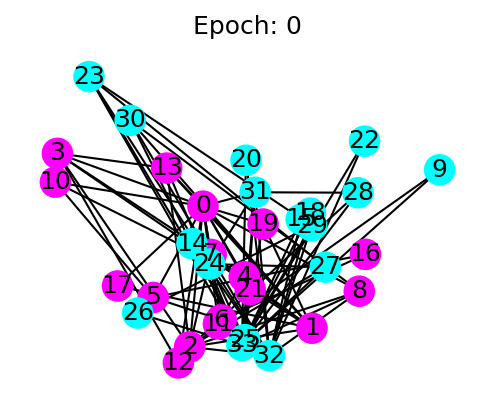

In [20]:
# Visualize the node classification using the logits output. Requires ffmpeg.
import networkx as nx
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
nx_G = g.to_networkx()
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pred = all_logits[i].numpy()
        pos[v] = pred[v]
        cls = labels[v]
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw(nx_G.to_undirected(), pos, node_color=colors, with_labels=True, node_size=200)

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())